In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, accuracy_score
import numpy as np



df = pd.read_csv('processed_data.csv')
print(f"Shape: {df.shape}")



Shape: (3630, 42)


In [ ]:
# 2. Define Features (X) and Target (y)
X = df.drop('Target', axis=1)
y = df['Target']

print("Features and Target defined.")

Features and Target defined.


In [ ]:
# 3. Split the data
# 80% for training, 20% for testing
# random_state=42 ensures the split is the same every time the code is run
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training Data: {X_train.shape}")
print(f"Testing Data: {X_test.shape}")

Training Data: (2904, 41)
Testing Data: (726, 41)


In [ ]:
# 4. Initialize and Train Logistic Regression
# max_iter=5000 gives the math enough time to find the best answer
model = LogisticRegression(max_iter=5000, random_state=42)
model.fit(X_train, y_train)

print("Model Trained!")

Model Trained!


In [ ]:
# 5. Predict and Evaluate
y_pred = model.predict(X_test)

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred)
print("="*30)
print(f" ACCURACY: {accuracy * 100:.2f}%")
print("="*30)

# Show detailed report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Dropout', 'Graduate']))



 ACCURACY: 91.46%

Classification Report:
              precision    recall  f1-score   support

     Dropout       0.92      0.84      0.88       277
    Graduate       0.91      0.96      0.93       449

    accuracy                           0.91       726
   macro avg       0.92      0.90      0.91       726
weighted avg       0.92      0.91      0.91       726



In [ ]:
# Save the model
pickle.dump(model, open('logistic_model.pkl', 'wb'))
print(" Model saved as 'logistic_model.pkl'")

 Model saved as 'logistic_model.pkl'



3. TRAINING vs TESTING ACCURACY (POC CHECK)
Training Accuracy: 0.9160 (91.60%)
Testing Accuracy:  0.9146 (91.46%)
 Status: GOOD FIT (Balanced Model)

2. SAMPLE PREDICTIONS (Minimum 6)
Student ID   | Actual     | Predicted  | Result
--------------------------------------------------
1779         | Graduate   | Graduate   |  Correct
2476         | Graduate   | Graduate   |  Correct
1236         | Graduate   | Graduate   |  Correct
610          | Dropout    | Dropout    |  Correct
3212         | Graduate   | Graduate   |  Correct
718          | Dropout    | Graduate   |  Wrong

4 & 5. COMPLETE CONFUSION MATRIX


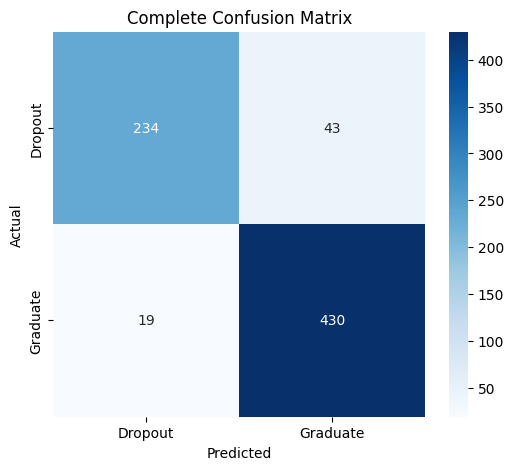


5-9. ROC CURVE & OPTIMUM THRESHOLD CALCULATION
 Optimum Threshold: 0.6097
   (At this point: TPR=0.9332, FPR=0.1191)
 AUC Score: 0.9560 (Probability of correct ranking)


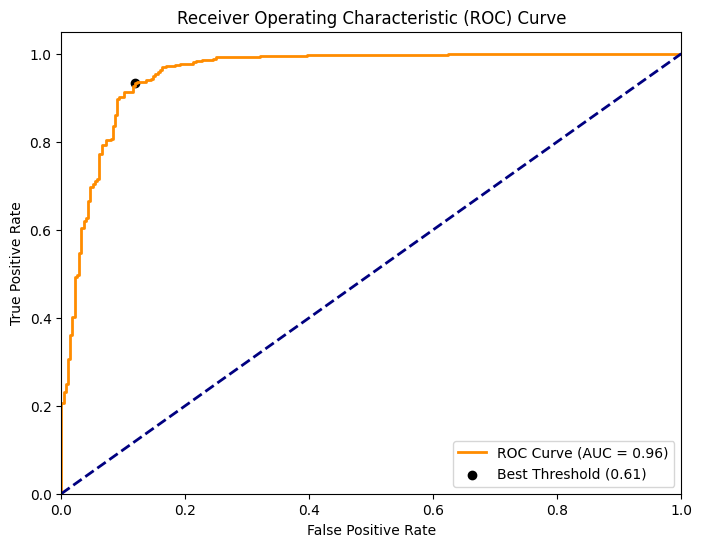

In [ ]:


# Calculate Train vs Test Accuracy ---
print("\n" + "="*50)
print("3. TRAINING vs TESTING ACCURACY (POC CHECK)")
print("="*50)
train_acc = model.score(X_train, y_train)
test_acc = model.score(X_test, y_test)
print(f"Training Accuracy: {train_acc:.4f} ({(train_acc*100):.2f}%)")
print(f"Testing Accuracy:  {test_acc:.4f} ({(test_acc*100):.2f}%)")

if train_acc - test_acc > 0.05:
    print(" Status: OVERFITTING DETECTED (Train >> Test)")
else:
    print(" Status: GOOD FIT (Balanced Model)")


#  Sample Predictions ---
print("\n" + "="*50)
print("2. SAMPLE PREDICTIONS (Minimum 6)")
print("="*50)
# Pick 6 random students from the test set
indices = np.random.choice(X_test.index, size=6, replace=False)
sample_X = X_test.loc[indices]
sample_y = y_test.loc[indices]

# Predict
sample_preds = model.predict(sample_X)
sample_probs = model.predict_proba(sample_X)[:, 1]

# Print Table
print(f"{'Student ID':<12} | {'Actual':<10} | {'Predicted':<10} | {'Result'}")
print("-" * 50)
for i in range(6):
    sid = indices[i]
    act = "Graduate" if sample_y.iloc[i] == 1 else "Dropout"
    pred = "Graduate" if sample_preds[i] == 1 else "Dropout"
    res = " Correct" if act == pred else " Wrong"
    print(f"{sid:<12} | {act:<10} | {pred:<10} | {res}")


# : Complete Confusion Matrix ---
print("\n" + "="*50)
print("4 & 5. COMPLETE CONFUSION MATRIX")
print("="*50)
cm = confusion_matrix(y_test, model.predict(X_test))

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Dropout', 'Graduate'],
            yticklabels=['Dropout', 'Graduate'])
plt.title('Complete Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


# ROC Curve & Optimum Threshold ---
print("\n" + "="*50)
print("5-9. ROC CURVE & OPTIMUM THRESHOLD CALCULATION")
print("="*50)

# 1. Get Probabilities
y_probs = model.predict_proba(X_test)[:, 1]

# 2. Calculate FPR, TPR, and Thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# 3. Calculate Optimum Threshold (Youden's J Statistic)
# J = TPR - FPR. The max J is the "Optimum Point".
J = tpr - fpr
ix = np.argmax(J) # Find the index of the highest J
best_thresh = thresholds[ix]

print(f" Optimum Threshold: {best_thresh:.4f}")
print(f"   (At this point: TPR={tpr[ix]:.4f}, FPR={fpr[ix]:.4f})")
print(f" AUC Score: {roc_auc:.4f} (Probability of correct ranking)")

# 4. Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# Mark the optimum point
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label=f'Best Threshold ({best_thresh:.2f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()